# Strategy Details
This strategy is based on the followin paper:  Klaus Grobys, Veda Fatmy and Topias Rajalin, Combining low-volatility and momentum: recent evidence from the Nordic equities, Applied Economics, 2024
The idea is that: Low volatility anomaly can be combined with the momentum anomaly to enhance risk-adjusted returns.

The research on combined low-volatility and momentum investment strategies has primarily focused on the Nordic stock markets. However, it would be valuable to explore whether these combined strategies can also improve the performance of a pure-play momentum strategy in the context of the S&P 500.

In [1]:
# Collect the list of the S&P 500 companies from Wikipedia and save it to a file
import os
import requests
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings("ignore")

# Get the list of S&P 500 companies from Wikipedia
url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'
response = requests.get(url)
html = response.content

df = pd.read_html(html, header=0)[0]

tickers = df['Symbol'].tolist()

In [2]:
# Load the data from yahoo finance
import os
import yfinance as yf

def load_data(symbol):

    direc = 'data/'
    os.makedirs(direc, exist_ok=True)

    file_name = os.path.join(direc, symbol + '.csv')

    if not os.path.exists(file_name):

        ticker = yf.Ticker(symbol)
        df = ticker.history(start='2005-01-01', end='2023-12-31')

        df.to_csv(file_name)

    df = pd.read_csv(file_name, index_col=0)
    df.index = pd.to_datetime(df.index, utc=True).tz_convert('US/Eastern')
    df['date'] = df.index

    if len(df) == 0:
        os.remove(file_name)
        return None

    return df

holder = []
ticker_with_data = []
for symbol in tickers:
    df = load_data(symbol)
    if df is not None:
        if len(df) > 3*252:
            holder.append(df)
            ticker_with_data.append(symbol)

tickers = ticker_with_data[:]

print (f'Loaded data for {len(tickers)} companies')

BRK.B: No timezone found, symbol may be delisted
BF.B: No price data found, symbol may be delisted (1d 2005-01-01 -> 2023-12-31)
GEV: Data doesn't exist for startDate = 1104555600, endDate = 1703998800
SOLV: Data doesn't exist for startDate = 1104555600, endDate = 1703998800


Loaded data for 495 companies


In [3]:
# Get the monthly data as we use the monthly data to calculate the momentum
monthly_data = []
for data in holder:
    df = data.resample('M').agg({
        'date': 'first',
        'Open': 'first',
        'High': 'max',
        'Low': 'min',
        'Close': 'last',
        'Volume': 'sum'
    })

    df.set_index('date', inplace=True)

    # convert the date time to year-month
    df.index = df.index.to_period('M')

    monthly_data.append(df)


# Add the monthly returns and the volatilties

Assume we will open at the monthly open price and will close at the monthly close.

In [4]:
# Calculate the monthly returns
temp = []
for df in monthly_data:
    df['intra_month_return'] = df['Close'] / df['Open'] - 1
    df['next_intra_month_return'] = df['intra_month_return'].shift(-1)
    df['monthly_return'] = df['Close'].pct_change()
    
    # Last 12 months return except the current month
    df['rolling_12_months_return'] = df['monthly_return'].rolling(11).sum().shift()

    temp.append(df)

monthly_data = temp

In the research paper, weekly data are used to calculated the volatility. Here, we use daily returns to calculate the standard deviation of 3 years historical data

In [5]:
# Calculate the volatility using historical data of the last 3 years
for df in holder:
    df['daily_return'] = df['Close'].pct_change()
    df['rolling_3_years_volatility'] =df['daily_return'].rolling(3*252).std()
    df['last_month_rolling_3_years_volatility'] = df['rolling_3_years_volatility'].shift()

monthly_3_years_volatility_data = []
for df in holder:
    temp = df.copy()
    temp = temp.resample('M').agg({'date': 'first','last_month_rolling_3_years_volatility': 'first'})
    temp.set_index('date', inplace=True)
    temp.dropna(inplace=True)
    # Convert the date time to year-month format
    temp.index = temp.index.to_period('M')
    monthly_3_years_volatility_data.append(temp)

In [6]:
# Add the last_month_rolling_3_years_volatilityto monthly data
for i in range(len(monthly_data)):
    monthly_data[i] = pd.concat([monthly_data[i], monthly_3_years_volatility_data[i]], axis=1)

    #The backtesting period start from 2008-01-02
    monthly_data[i] = monthly_data[i].loc['2008-01-01':]

In [7]:
rolling_12_months_return_holder = []
next_intra_month_return_holder = []
last_month_rolling_3_years_std_holder = []
intra_month_reutrn_holder = []

# Creating tables with symbols as columns and the date as rows
for symbol, df in zip(tickers, monthly_data):

    rolling_12_months_return_series = df['rolling_12_months_return'].copy()
    next_intra_month_return_series = df['next_intra_month_return'].copy()
    last_month_rolling_3_years_std_series = df['last_month_rolling_3_years_volatility'].copy()
    
    rolling_12_months_return_series.name = symbol
    next_intra_month_return_series.name = symbol
    last_month_rolling_3_years_std_series.name = symbol

    rolling_12_months_return_holder.append(rolling_12_months_return_series)
    next_intra_month_return_holder.append(next_intra_month_return_series)
    last_month_rolling_3_years_std_holder.append(last_month_rolling_3_years_std_series)
  
# Create the final dataframes 
rolling_12_months_return_df = pd.concat(rolling_12_months_return_holder, axis=1, ignore_index=False)
next_intra_month_return_df = pd.concat(next_intra_month_return_holder, axis=1, ignore_index=False)
last_month_rolling_3_years_std_df = pd.concat(last_month_rolling_3_years_std_holder, axis=1, ignore_index=False)


print (rolling_12_months_return_df.iloc[:3, :4])
print (next_intra_month_return_df.iloc[:3, :4])
print (last_month_rolling_3_years_std_df.iloc[:3, :4])


              MMM       AOS       ABT  ABBV
date                                       
2008-01  0.165248 -0.037589  0.081723   NaN
2008-02  0.105294 -0.041811  0.057131   NaN
2008-03  0.065304  0.010470 -0.011287   NaN
              MMM       AOS       ABT  ABBV
date                                       
2008-01 -0.010007  0.037006 -0.055389   NaN
2008-02  0.012667 -0.094490  0.033352   NaN
2008-03 -0.034041 -0.069337 -0.037960   NaN
              MMM       AOS       ABT  ABBV
date                                       
2008-01  0.011269  0.021270  0.011481   NaN
2008-02  0.011350  0.021901  0.011652   NaN
2008-03  0.011437  0.022053  0.011725   NaN


# Regression Analysis

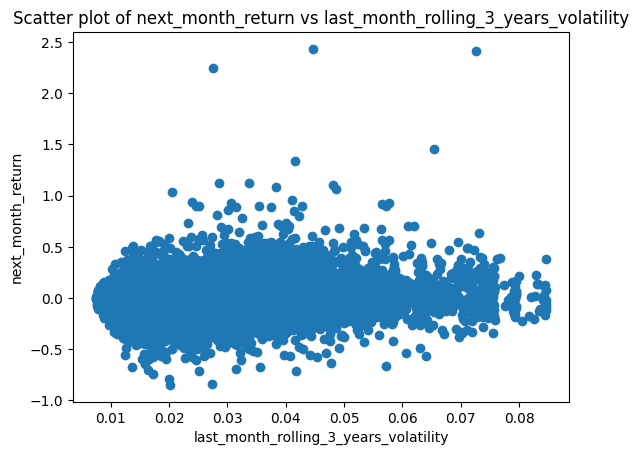

Correlation between the next month return and the last month volatility is 0.05555081177330032


<class 'statsmodels.iolib.summary.Summary'>
"""
                               OLS Regression Results                              
===================================================================================
Dep. Variable:     next_intra_month_return   R-squared:                       0.003
Model:                                 OLS   Adj. R-squared:                  0.003
Method:                      Least Squares   F-statistic:                     268.4
Date:                     Wed, 19 Jun 2024   Prob (F-statistic):           3.17e-60
Time:                             14:44:22   Log-Likelihood:                 83215.
No. Observations:                    86701   AIC:                        -1.664e+05
Df Residuals:                        86699   BIC:                        -1.664e+05
Df Model:                                1                                         
Covariance Type:                 nonrobust                                         
=========================================================================================================
                                            coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
const                                     0.0003      0.001      0.328      0.743      -0.001       0.002
last_month_rolling_3_years_volatility     0.5680      0.035     16.382      0.000       0.500       0.636
==============================================================================
Omnibus:                    30738.657   Durbin-Watson:                   2.050
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1754199.939
Skew:                           0.910   Prob(JB):                         0.00
Kurtosis:                      24.961   Cond. No.                         110.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

regression_holder = []
for df in monthly_data:
    regression_holder.append(df[['rolling_12_months_return','next_intra_month_return', 'last_month_rolling_3_years_volatility']].dropna())

df_for_regression = pd.concat(regression_holder, axis = 0, ignore_index=True)

plt.scatter(df_for_regression['last_month_rolling_3_years_volatility'], df_for_regression['next_intra_month_return'])
plt.xlabel('last_month_rolling_3_years_volatility')
plt.ylabel('next_month_return')
plt.title('Scatter plot of next_month_return vs last_month_rolling_3_years_volatility')
plt.show()

# Calculate the correlation between the next month return and the last month volatility
correlation = df_for_regression['next_intra_month_return'].corr(df_for_regression['last_month_rolling_3_years_volatility'])
print (f'Correlation between the next month return and the last month volatility is {correlation}')


X = sm.add_constant(df_for_regression['last_month_rolling_3_years_volatility'])
y = df_for_regression['next_intra_month_return']

model = sm.OLS(y, X).fit()
model.summary()


## Analysis of the Results

1. The p-value of the coefficient of last_month_rolling_3_years_volatility is 0.000, which is statistically significant 
2. The next intra month return is positively correlated with the volatility

### Possible Reason for the positive coefficient

1. There's a mistake in the code. Please let me know if you find any to make the code correct
2. The low volatility effect which is somewhat counterintuitive, may be weaker in the context of S&P 500.
3. The time period that we used for the analysis is different from the time period that the momentum effect was found in the literature.
4. Maybe the effect can be found in the tails.

## What do we do now?

Let's do the regression on the tails of the volatility distribution for each month. It means, that we may see the effect of low volatility and high volatility.

### Regression on both tails of high volatility and low volatility

In [9]:
# Numbers of stocks to long or short
N = 10

low_vol_stocks = last_month_rolling_3_years_std_df.mask(last_month_rolling_3_years_std_df.rank(axis=1, method='dense', ascending=False) > N,np.nan)
high_vol_stocks = last_month_rolling_3_years_std_df.mask(last_month_rolling_3_years_std_df.rank(axis=1, method='dense', ascending=True) > N,np.nan)

low_vol_stocks_symbols = low_vol_stocks.apply(lambda row: row.dropna().index.tolist(), axis=1)
high_vol_stocks_symbols = high_vol_stocks.apply(lambda row: row.dropna().index.tolist(), axis=1)

mask = low_vol_stocks.notna() | high_vol_stocks.notna()
last_month_rolling_3_years_std_df_for_tail_regression = last_month_rolling_3_years_std_df[mask]
next_intra_month_return_df_for_tail_regression = next_intra_month_return_df[mask]

# Flatten the data
vol_holder = []
return_holder = []

for i in range(len(last_month_rolling_3_years_std_df_for_tail_regression)):
    vol_holder.extend(last_month_rolling_3_years_std_df_for_tail_regression.iloc[i].values)
    return_holder.extend(next_intra_month_return_df_for_tail_regression.iloc[i].values)

last_month_rolling_3_years_std_df_for_tail_regression = pd.Series(vol_holder)
next_intra_month_return_df_for_tail_regression = pd.Series(return_holder)

last_month_rolling_3_years_std_df_for_tail_regression.name = 'last_month_rolling_3_years_std'
next_intra_month_return_df_for_tail_regression.name = 'next_intra_month_return'

df_for_tail_regression = pd.concat([last_month_rolling_3_years_std_df_for_tail_regression, next_intra_month_return_df_for_tail_regression], axis=1)
df_for_tail_regression.dropna(inplace=True)

X = sm.add_constant(df_for_tail_regression['last_month_rolling_3_years_std'])
Y = df_for_tail_regression['next_intra_month_return']

model = sm.OLS(Y, X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               OLS Regression Results                              
===================================================================================
Dep. Variable:     next_intra_month_return   R-squared:                       0.007
Model:                                 OLS   Adj. R-squared:                  0.007
Method:                      Least Squares   F-statistic:                     26.41
Date:                     Wed, 19 Jun 2024   Prob (F-statistic):           2.90e-07
Time:                             14:44:22   Log-Likelihood:                 2128.8
No. Observations:                     3820   AIC:                            -4254.
Df Residuals:                         3818   BIC:                            -4241.
Df Model:                                1                                         
Covariance Type:                 nonrobust                                         
==================================================================================================
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const                              0.0041      0.004      1.053      0.293      -0.004       0.012
last_month_rolling_3_years_std     0.5668      0.110      5.139      0.000       0.351       0.783
==============================================================================
Omnibus:                     2575.849   Durbin-Watson:                   1.608
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           162591.976
Skew:                           2.522   Prob(JB):                         0.00
Kurtosis:                      34.561   Cond. No.                         49.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### Regression on only the tail of low volatility

In [10]:
# Numbers of stocks to long 
N = 20

low_vol_stocks = last_month_rolling_3_years_std_df.mask(last_month_rolling_3_years_std_df.rank(axis=1, method='dense', ascending=False) > N,np.nan)

low_vol_stocks_symbols = low_vol_stocks.apply(lambda row: row.dropna().index.tolist(), axis=1)


mask = low_vol_stocks.notna()
last_month_rolling_3_years_std_df_for_tail_regression = last_month_rolling_3_years_std_df[mask]
next_intra_month_return_df_for_tail_regression = next_intra_month_return_df[mask]

# Flatten the data
vol_holder = []
return_holder = []

for i in range(len(last_month_rolling_3_years_std_df_for_tail_regression)):
    vol_holder.extend(last_month_rolling_3_years_std_df_for_tail_regression.iloc[i].values)
    return_holder.extend(next_intra_month_return_df_for_tail_regression.iloc[i].values)

last_month_rolling_3_years_std_df_for_tail_regression = pd.Series(vol_holder)
next_intra_month_return_df_for_tail_regression = pd.Series(return_holder)

last_month_rolling_3_years_std_df_for_tail_regression.name = 'last_month_rolling_3_years_std'
next_intra_month_return_df_for_tail_regression.name = 'next_intra_month_return'

df_for_tail_regression = pd.concat([last_month_rolling_3_years_std_df_for_tail_regression, next_intra_month_return_df_for_tail_regression], axis=1)
df_for_tail_regression.dropna(inplace=True)

X = sm.add_constant(df_for_tail_regression['last_month_rolling_3_years_std'])
Y = df_for_tail_regression['next_intra_month_return']

model = sm.OLS(Y, X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               OLS Regression Results                              
===================================================================================
Dep. Variable:     next_intra_month_return   R-squared:                       0.001
Model:                                 OLS   Adj. R-squared:                  0.000
Method:                      Least Squares   F-statistic:                     2.089
Date:                     Wed, 19 Jun 2024   Prob (F-statistic):              0.148
Time:                             14:44:22   Log-Likelihood:                 1247.3
No. Observations:                     3820   AIC:                            -2491.
Df Residuals:                         3818   BIC:                            -2478.
Df Model:                                1                                         
Covariance Type:                 nonrobust                                         
==================================================================================================
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const                              0.0137      0.009      1.506      0.132      -0.004       0.031
last_month_rolling_3_years_std     0.3003      0.208      1.445      0.148      -0.107       0.708
==============================================================================
Omnibus:                     2054.668   Durbin-Watson:                   1.454
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            66133.463
Skew:                           1.965   Prob(JB):                         0.00
Kurtosis:                      23.001   Cond. No.                         73.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Analysis of the Results

- The regression includes high volatility shows quite strong positive correaltion between volatility and returns which is against the low volatility effect.
- However, when we run the regression only on the low volatility stocks: 
    1. There is still a positive correlation between volatility and returns
    2. But the p-value for this relationship is greater than 0.1
    3. The 95% confidence interval for the slope coefficient includes -0.107 This suggests the existence of the low volatility effect, even if the relationship is not as strong as the traditional theory would predict. At least we can give it a shot.

# Strategy Implementation on the Whole Universe of S&P500

In [11]:
# Build a table to store the results from 4 portfolios using portfolio name as rows and metrics as columns
columns = ['Total Return', 'Annualized Return', 'Annualized Volatility', 'Sharpe Ratio', 'VaR']
index = ['Pure Momentum Portfolio','High Momentum Portfolio','Pure Volatility Portfolio', 'Low Volatility Portfolio', 
         'High Momentum First Low Volatility Portfolio', 'Low Volatility First High Momentum Portfolio',
         'Low Momentum First High Volatility Portfolio', 'High Volatility First Low Momentum Portfolio']
results_df = pd.DataFrame(index=index, columns=columns)

## Pure Paly Portfolios

### Pure Momentum Portfolio

To build a pure-play mometum portfolio, first, calculate a momentum score for each stock based on its recent 12 month returns exculding the nearest month. Then, identify the stocks with the highest momentum scores and the lowest momentum score. Construct the portfolio by taking a long position in the high momentum stocks and a short positon on the low momentum stocks. 
Rebalance the portfolio monthly by recalculating the momentum scores and adjusting the long and short positions accordingly. 

In [12]:
# Select the top N and bottom N stocks based on the momentum
N = len(tickers)//2
high_momentum_mask = rolling_12_months_return_df.rank(axis=1, method='dense', ascending=True) > N
low_momentum_mask = rolling_12_months_return_df.rank(axis=1, method='dense', ascending=False) > N

returns_df_for_pure_momentum = pd.DataFrame(index=rolling_12_months_return_df.index, columns=rolling_12_months_return_df.columns)
returns_df_for_pure_momentum.iloc[:, :] = np.nan

# Assign the returns to the pure momentum portfolio
returns_df_for_pure_momentum[high_momentum_mask] = next_intra_month_return_df[high_momentum_mask]
# As we take short position for low momentum stocks, we need to multiply by -1
returns_df_for_pure_momentum[low_momentum_mask] = -next_intra_month_return_df[low_momentum_mask]

equal_weighted_returns = returns_df_for_pure_momentum.mean(axis=1, skipna=True).shift()

print (equal_weighted_returns.tail())

date
2023-08    0.009234
2023-09    0.000376
2023-10    -0.00074
2023-11    0.007475
2023-12   -0.014388
Freq: M, dtype: object


The accumulated return for the equal weighted portfolio is:  0.7691815046013217
The annualized return for the equal weighted portfolio is:  -0.0013658804523933865
The annualized volatility for the equal weighted portfolio is:  0.05145916411809835
The Sharpe ratio for the equal weighted portfolio is:  -0.02654299726398008
The VaR for the equal weighted portfolio is:  -0.02216870131782817


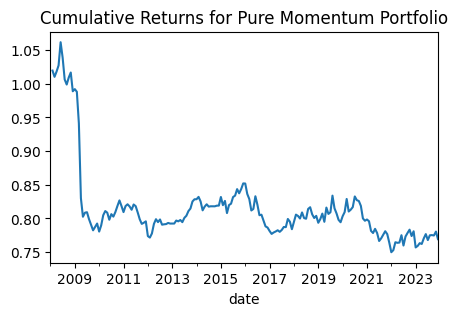

In [13]:
# Calculate the cumulative returns
cumulative_returns = (1 + equal_weighted_returns).cumprod()
print("The accumulated return for the equal weighted portfolio is: ", cumulative_returns[-1])

# Calculate the annualized return
annualized_return = (cumulative_returns[-1])**(1/len(cumulative_returns)) - 1
print("The annualized return for the equal weighted portfolio is: ", annualized_return)

# Calculate the annualized volatility
annualized_volatility = equal_weighted_returns.std() * np.sqrt(12)
print("The annualized volatility for the equal weighted portfolio is: ", annualized_volatility)

# Calculate the Sharpe ratio
sharpe_ratio = annualized_return / annualized_volatility
print("The Sharpe ratio for the equal weighted portfolio is: ", sharpe_ratio)

# Calculate the VaR
VaR = equal_weighted_returns.quantile(0.05)
print("The VaR for the equal weighted portfolio is: ", VaR)

# Plot the cumulative returns
import matplotlib.pyplot as plt
plt.figure(figsize=(5, 3))
cumulative_returns.plot()
plt.title('Cumulative Returns for Pure Momentum Portfolio')
plt.show()

# Store the results in the results dataframe
results_df.loc['Pure Momentum Portfolio', 'Total Return'] = cumulative_returns[-1]
results_df.loc['Pure Momentum Portfolio', 'Annualized Return'] = annualized_return
results_df.loc['Pure Momentum Portfolio', 'Annualized Volatility'] = annualized_volatility
results_df.loc['Pure Momentum Portfolio', 'Sharpe Ratio'] = sharpe_ratio
results_df.loc['Pure Momentum Portfolio', 'VaR'] = VaR

### Pure-play High Momentum Portfolio

Similar to pure momentum portfolio, but this time returns are only obtained through long positions in high momentum stocks

In [14]:
N = len(tickers) // 2
high_momentum_mask = rolling_12_months_return_df.rank(axis=1, method='dense', ascending=True) > N
# Get the returns for the high momentum stocks
returns_df_for_pure_high_momentum = next_intra_month_return_df [high_momentum_mask]
# Build the equal weighted portfolio for the high momentum stocks
equal_weight_portfolio_pure_high_momentum = returns_df_for_pure_high_momentum.mean(axis=1).shift()


The accumulative return of the high momentum portfolio is: 6.349371315522752
The annualized return of the high momentum portfolio is: 0.12245947514388233
The annualized volatility of the high momentum portfolio is: 0.17253032237984114
The Sharpe ratio of the high momentum portfolio is: 0.709785233428572
The VaR at 95% confidence level of the high momentum portfolio is: -0.08128805130335756


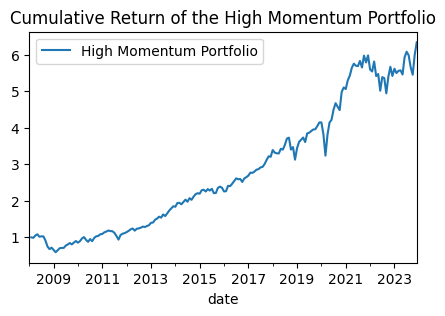

In [15]:
# calculate the cumulative return
cumulative_return_high_momentum = (1 + equal_weight_portfolio_pure_high_momentum).cumprod()
print("The accumulative return of the high momentum portfolio is:", cumulative_return_high_momentum[-1])

# Calculate the annualized return
annualized_return_high_momentum = cumulative_return_high_momentum[-1] ** (12 / len(cumulative_return_high_momentum)) - 1
print("The annualized return of the high momentum portfolio is:", annualized_return_high_momentum)

# Calculate the annualized volatility
annualized_volatility_high_momentum = equal_weight_portfolio_pure_high_momentum.std() * np.sqrt(12)
print("The annualized volatility of the high momentum portfolio is:", annualized_volatility_high_momentum)

# Calculate the Sharpe ratio
sharpe_ratio_high_momentum = annualized_return_high_momentum / annualized_volatility_high_momentum
print("The Sharpe ratio of the high momentum portfolio is:", sharpe_ratio_high_momentum)

# Calculate the VaR at 95% confidence level
VaR_95_high_momentum = equal_weight_portfolio_pure_high_momentum.quantile(0.05)
print("The VaR at 95% confidence level of the high momentum portfolio is:", VaR_95_high_momentum)

# Plot the cumulative return of the high momentum portfolio
plt.figure(figsize=(5, 3))
cumulative_return_high_momentum.plot(label='High Momentum Portfolio')
plt.title('Cumulative Return of the High Momentum Portfolio')
plt.legend()
plt.show()

# Store the results in the results table
results_df.loc['High Momentum Portfolio', 'Total Return'] = cumulative_return_high_momentum[-1]
results_df.loc['High Momentum Portfolio', 'Annualized Return'] = annualized_return_high_momentum
results_df.loc['High Momentum Portfolio', 'Annualized Volatility'] = annualized_volatility_high_momentum
results_df.loc['High Momentum Portfolio', 'Sharpe Ratio'] = sharpe_ratio_high_momentum
results_df.loc['High Momentum Portfolio', 'VaR'] = VaR_95_high_momentum


### Pure Volatility Portfolio

In [16]:
N = len(tickers) // 2
high_volatility_mask = last_month_rolling_3_years_std_df.rank(axis=1, method='dense', ascending=True) > N
low_volatility_mask = last_month_rolling_3_years_std_df.rank(axis=1, method='dense', ascending=False) > N
# Get the returns
returns_df_for_pure_volatility = pd.DataFrame(index=last_month_rolling_3_years_std_df.index, columns=last_month_rolling_3_years_std_df.columns)
returns_df_for_pure_volatility.iloc[:, :] = np.nan
returns_df_for_pure_volatility[high_volatility_mask] = next_intra_month_return_df[high_volatility_mask]
returns_df_for_pure_volatility[low_volatility_mask] = -next_intra_month_return_df[low_volatility_mask]
# Build the equal weighted portfolio
equal_weighted_returns = returns_df_for_pure_volatility.mean(axis=1, skipna=True).shift()


The accumulated return for the equal weighted portfolio is:  1.5944977360649883
The annualized return for the equal weighted portfolio is:  0.002432948513132027
The annualized volatility for the equal weighted portfolio is:  0.0647798777835945
The Sharpe ratio for the equal weighted portfolio is:  0.037557164298142154
The VaR for the equal weighted portfolio is:  -0.026321747012300285


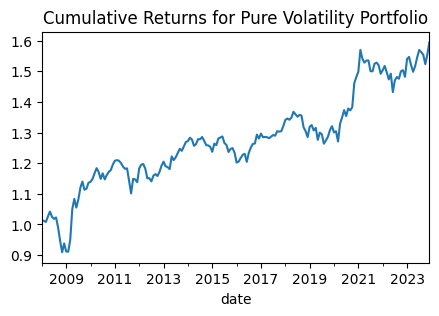

In [17]:
# Calculate the cumulative returns
cumulative_returns = (1 + equal_weighted_returns).cumprod()
print("The accumulated return for the equal weighted portfolio is: ", cumulative_returns[-1])

# Calculate the annualized return
annualized_return = (cumulative_returns[-1])**(1/len(cumulative_returns)) - 1
print("The annualized return for the equal weighted portfolio is: ", annualized_return)

# Calculate the annualized volatility
annualized_volatility = equal_weighted_returns.std() * np.sqrt(12)
print("The annualized volatility for the equal weighted portfolio is: ", annualized_volatility)

# Calculate the Sharpe ratio
sharpe_ratio = annualized_return / annualized_volatility
print("The Sharpe ratio for the equal weighted portfolio is: ", sharpe_ratio)

# Calculate the VaR
VaR = equal_weighted_returns.quantile(0.05)
print("The VaR for the equal weighted portfolio is: ", VaR)

# Plot the cumulative returns
plt.figure(figsize=(5, 3))
cumulative_returns.plot()
plt.title('Cumulative Returns for Pure Volatility Portfolio')
plt.show()

# Store the results in the results table
results_df.loc['Pure Volatility Portfolio', 'Total Return'] = cumulative_returns[-1]
results_df.loc['Pure Volatility Portfolio', 'Annualized Return'] = annualized_return
results_df.loc['Pure Volatility Portfolio', 'Annualized Volatility'] = annualized_volatility
results_df.loc['Pure Volatility Portfolio', 'Sharpe Ratio'] = sharpe_ratio
results_df.loc['Pure Volatility Portfolio', 'VaR'] = VaR

### Pure Low-Volatility Portfolio

Similar to pure high momentum portfolio, but this time returns are only obtained by taking short position on low volatility stocks 

In [18]:
N = len(tickers) // 2
low_volatility_mask = last_month_rolling_3_years_std_df.rank(axis=1, method='dense', ascending=False) > N

# Get the returns for the low volatility stocks
returns_df_for_pure_volatility = pd.DataFrame(index=last_month_rolling_3_years_std_df.index, columns=last_month_rolling_3_years_std_df.columns)
returns_df_for_pure_volatility.iloc[:, :] = np.nan
returns_df_for_pure_low_volatility = next_intra_month_return_df[low_volatility_mask]

equal_weight_portfolio_pure_low_volatility = returns_df_for_pure_low_volatility.mean(axis=1).shift()


The accumulative return of the low volatility portfolio is: 5.20876303780974
The Sharpe ratio of the low volatility portfolio is: 0.807953073545121
The annualized volatility of the low volatility portfolio is: 0.1412859447400129
The annualized return of the low volatility portfolio is: 0.11630355216396504
The VaR of the low volatility portfolio is: -0.05582272862570285


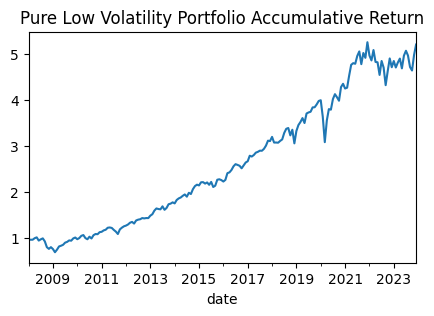

In [19]:
# calculate the cumulative return
cumulative_return_low_volatility = (1 + equal_weight_portfolio_pure_low_volatility).cumprod()
print("The accumulative return of the low volatility portfolio is:", cumulative_return_low_volatility[-1])

# Calculate the Sharpe ratio
sharpe_ratio = equal_weight_portfolio_pure_low_volatility.mean() / equal_weight_portfolio_pure_low_volatility.std()* np.sqrt(12)
print("The Sharpe ratio of the low volatility portfolio is:", sharpe_ratio)

# Calculate the annualized volatility
annualized_volatility = equal_weight_portfolio_pure_low_volatility.std() * np.sqrt(12)
print("The annualized volatility of the low volatility portfolio is:", annualized_volatility)

# Calculate the annualized return
annualized_return = (cumulative_return_low_volatility[-1]) ** (1/15) - 1
print("The annualized return of the low volatility portfolio is:", annualized_return)

# Calculate the VaR
VaR = equal_weight_portfolio_pure_low_volatility.quantile(0.05)
print("The VaR of the low volatility portfolio is:", VaR)

# Plot the cumulative return
plt.figure(figsize=(5, 3))
cumulative_return_low_volatility.plot(title='Pure Low Volatility Portfolio Accumulative Return')

# Store the results in the results table
results_df.loc['Low Volatility Portfolio', 'Total Return'] = cumulative_return_low_volatility[-1]
results_df.loc['Low Volatility Portfolio', 'Annualized Return'] = annualized_return
results_df.loc['Low Volatility Portfolio', 'Annualized Volatility'] = annualized_volatility
results_df.loc['Low Volatility Portfolio', 'Sharpe Ratio'] = sharpe_ratio
results_df.loc['Low Volatility Portfolio', 'VaR'] = VaR


## Double Screening: Combined Strategy

combination portfolios are created by double-screening stocks by volatility and momentum, and using both volatility-first and momentum-first sorting. For example, in the volatility-first double-screened combination portfolio, stocks are first sorted into two halves by volatility, and then by momentum. This process generates 2 porfolios: the high momentum stocks from the low volatility universe and the low momentum stocks form the high volatility universe. Long poisitons are taken for the former and short positions come with the latter. This allocation procedure is repeated vice versa for the momentum-first dobble-screened combination portfolios.

#### 1. Low-Volatility Stocks from High Momentum Universe

In [20]:
HighMomentumFirst_LowVolatility_df = pd.DataFrame(index = rolling_12_months_return_df.index, columns=rolling_12_months_return_df.columns)
HighMomentumFirst_LowVolatility_df.iloc[:, :] = np.nan

# Copy the rolling 12 months return dataframe to avoid changing the original dataframe
last_month_rolling_3_years_std_df_copy = last_month_rolling_3_years_std_df.copy()

# Firstly selecte the high momentum stocks
N_high_momentum = len(tickers) // 2
high_momentum_mask = rolling_12_months_return_df.rank(axis=1, method='dense', ascending=True) > N_high_momentum
HighMomentumFirst_LowVolatility_df[high_momentum_mask] = 1

# Set the low momentum stocks in the dataframe of volatility to be nan so that we will only select stocks of low volatility from the high momentum stocks
last_month_rolling_3_years_std_df_copy[~high_momentum_mask] = np.nan

# Select the low volatility stocks from the high momentum stocks

# Set the number of low volatility stocks to be half of the high momentum stocks number
N_low_volatility = N_high_momentum // 2
low_volatility_mask = last_month_rolling_3_years_std_df_copy.rank(axis=1, method='dense', ascending=False) > N_low_volatility
# Denote the low volatility stocks to be 1 and the high volatility stocks to be nan
HighMomentumFirst_LowVolatility_df[low_volatility_mask] = 1
HighMomentumFirst_LowVolatility_df[~low_volatility_mask] = np.nan

# Get the returns
returns_df_for_high_momentumFirst_low_volatility = pd.DataFrame(index=rolling_12_months_return_df.index, columns=rolling_12_months_return_df.columns)
returns_df_for_high_momentumFirst_low_volatility.iloc[:, :] = np.nan

# Perform element-wise multiplication to get the returns of the low volatility first high momentum portfolio
returns_df_for_high_momentumFirst_low_volatility = next_intra_month_return_df*HighMomentumFirst_LowVolatility_df

# Get the equal weighted portfolio
equal_weight_portfolio_high_momentumFirst_low_volatility = returns_df_for_high_momentumFirst_low_volatility.mean(axis=1, skipna=True).shift()

print(equal_weight_portfolio_high_momentumFirst_low_volatility.tail(5))


date
2023-08   -0.004718
2023-09   -0.048402
2023-10    -0.02217
2023-11    0.084242
2023-12     0.03477
Freq: M, dtype: object


Total return of the high momentum first low volatility portfolio is: 4.063850076714172
The annualized return of the high momentum first low volatility portfolio is: 0.09798357936540203
The annualized volatility of the high momentum first low volatility portfolio is: 0.1423127709170108
The Sharpe ratio of the high momentum first low volatility portfolio is: 0.6929207042804908
The VaR of the high momentum first low volatility portfolio is: -0.06202777553016986


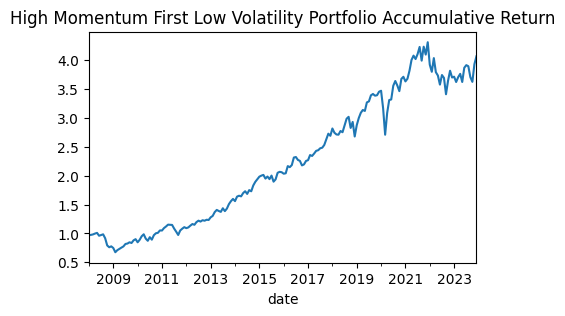

In [21]:
# Calculate the cumulative return
cumulative_return = (1 + equal_weight_portfolio_high_momentumFirst_low_volatility).cumprod()
print("Total return of the high momentum first low volatility portfolio is:", cumulative_return[-1])

# Calculate the annualized return
annualized_return = (cumulative_return[-1]) ** (1/15) - 1
print("The annualized return of the high momentum first low volatility portfolio is:", annualized_return)

# Calculate the annualized volatility
annualized_volatility = equal_weight_portfolio_high_momentumFirst_low_volatility.std() * np.sqrt(12)
print("The annualized volatility of the high momentum first low volatility portfolio is:", annualized_volatility)

# Cacluate the Sharpe ratio
sharpe_ratio = equal_weight_portfolio_high_momentumFirst_low_volatility.mean() / equal_weight_portfolio_high_momentumFirst_low_volatility.std() * np.sqrt(12)
print("The Sharpe ratio of the high momentum first low volatility portfolio is:", sharpe_ratio)

# Calculate the VaR
VaR = equal_weight_portfolio_high_momentumFirst_low_volatility.quantile(0.05)
print("The VaR of the high momentum first low volatility portfolio is:", VaR)

# Plot the cumulative return
plt.figure(figsize=(5, 3))
cumulative_return.plot(title='High Momentum First Low Volatility Portfolio Accumulative Return')

# Store the results in the results table
results_df.loc['High Momentum First Low Volatility Portfolio', 'Total Return'] = cumulative_return[-1]
results_df.loc['High Momentum First Low Volatility Portfolio', 'Annualized Return'] = annualized_return
results_df.loc['High Momentum First Low Volatility Portfolio', 'Annualized Volatility'] = annualized_volatility
results_df.loc['High Momentum First Low Volatility Portfolio', 'Sharpe Ratio'] = sharpe_ratio
results_df.loc['High Momentum First Low Volatility Portfolio', 'VaR'] = VaR


#### 2. High Momentum Stock from Low Volatility Universe

In [22]:
# Firstly selecte the low volatility stocks
LowVolatilityFirst_HighMomentum_df = pd.DataFrame(index = rolling_12_months_return_df.index, columns=rolling_12_months_return_df.columns)
LowVolatilityFirst_HighMomentum_df.iloc[:, :] = np.nan

# Copy the rolling 12 months return dataframe to avoid changing the original dataframe
rolling_12_months_return_df_copy = rolling_12_months_return_df.copy()

N_low_volatility = len(tickers) // 2
low_volatility_mask =last_month_rolling_3_years_std_df.rank(axis=1, method='dense', ascending=False) > N_low_volatility

LowVolatilityFirst_HighMomentum_df[low_volatility_mask] = 1
# Set the high volatility stocks to be nan so that we will only select stocks of high momentum from the low volatility stocks
rolling_12_months_return_df_copy[~low_volatility_mask] = np.nan

N_high_momentum = N_low_volatility // 2
# only select the high momentum stocks from the low volatility stocks
high_momentum_mask = rolling_12_months_return_df_copy.rank(axis=1, method='dense', ascending=True) > N_high_momentum
LowVolatilityFirst_HighMomentum_df[high_momentum_mask] = 1
LowVolatilityFirst_HighMomentum_df[~high_momentum_mask] = np.nan

# Get the returns   
returns_df_for_low_volatilityFirst_high_momentum = pd.DataFrame(index=rolling_12_months_return_df.index, columns=rolling_12_months_return_df.columns)
returns_df_for_low_volatilityFirst_high_momentum.iloc[:, :] = np.nan

# Perform element-wise multiplication to get the returns of the low volatility first high momentum portfolio
returns_df_for_low_volatilityFirst_high_momentum = next_intra_month_return_df*LowVolatilityFirst_HighMomentum_df

# Get the equal weighted portfolio
equal_weight_portfolio_low_volatilityFirst_high_momentum = returns_df_for_low_volatilityFirst_high_momentum.mean(axis=1, skipna=True).shift()

print(equal_weight_portfolio_low_volatilityFirst_high_momentum.tail(5))


date
2023-08   -0.005084
2023-09   -0.046792
2023-10   -0.020267
2023-11     0.07957
2023-12    0.032711
Freq: M, dtype: object


Total return of the low volatility first high momentum portfolio is: 3.7510484838952194
The annualized return of the low volatility first high momentum portfolio is: 0.09213630734314493
The annualized volatility of the low volatility first high momentum portfolio is: 0.1431649341870104
The Sharpe ratio of the low volatility first high momentum portfolio is: 0.6542600132298477
The VaR of the low volatility first high momentum portfolio is: -0.06770933682095417


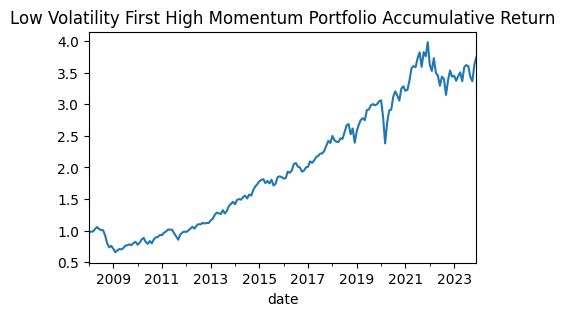

In [23]:
# Calculate the cumulative return
cumulative_return = (1 + equal_weight_portfolio_low_volatilityFirst_high_momentum).cumprod()
print("Total return of the low volatility first high momentum portfolio is:", cumulative_return[-1])

# Calculate the annualized return
annualized_return = (cumulative_return[-1]) ** (1/15) - 1
print("The annualized return of the low volatility first high momentum portfolio is:", annualized_return)

# Calculate the annualized volatility
annualized_volatility = equal_weight_portfolio_low_volatilityFirst_high_momentum.std() * np.sqrt(12)
print("The annualized volatility of the low volatility first high momentum portfolio is:", annualized_volatility)

# Cacluate the Sharpe ratio
sharpe_ratio = equal_weight_portfolio_low_volatilityFirst_high_momentum.mean() / equal_weight_portfolio_low_volatilityFirst_high_momentum.std() * np.sqrt(12)
print("The Sharpe ratio of the low volatility first high momentum portfolio is:", sharpe_ratio)

# Calculate the VaR
VaR = equal_weight_portfolio_low_volatilityFirst_high_momentum.quantile(0.05)
print("The VaR of the low volatility first high momentum portfolio is:", VaR)

# Plot the cumulative return
plt.figure(figsize=(5, 3))
cumulative_return.plot(title='Low Volatility First High Momentum Portfolio Accumulative Return')

# Store the results in the results table
results_df.loc['Low Volatility First High Momentum Portfolio', 'Total Return'] = cumulative_return[-1]
results_df.loc['Low Volatility First High Momentum Portfolio', 'Annualized Return'] = annualized_return
results_df.loc['Low Volatility First High Momentum Portfolio', 'Annualized Volatility'] = annualized_volatility
results_df.loc['Low Volatility First High Momentum Portfolio', 'Sharpe Ratio'] = sharpe_ratio
results_df.loc['Low Volatility First High Momentum Portfolio', 'VaR'] = VaR

#### 3. High Volatility from Low Momentum Universe

In [24]:
# Firstly selecte the low momentum stocks
LowMomentumFirst_HighVolatility_df = pd.DataFrame(index=rolling_12_months_return_df.index, columns=rolling_12_months_return_df.columns)
LowMomentumFirst_HighVolatility_df.iloc[:,:] = np.nan

# Copy the last_month_rolling_3_years_std dataframe to avoid changing the original dataframe
last_month_rolling_3_years_std_df_copy = last_month_rolling_3_years_std_df.copy()

# Firstly selecte the low momentum stocks
N_low_momentum = len(tickers) // 2
low_momentum_mask = rolling_12_months_return_df.rank(axis=1, method='dense', ascending=False) > N_low_momentum
LowMomentumFirst_HighVolatility_df[low_momentum_mask] = -1

# Set the high momentum stocks to be nan so that we will only select stocks of high volatility from the low momentum stocks
last_month_rolling_3_years_std_df_copy[~low_momentum_mask] = np.nan

# Select the high volatility stocks from the low momentum stocks

# Set the number of high volatility stocks to be half of the low momentum stocks number
N_high_volatility = N_low_momentum // 2
high_volatility_mask = last_month_rolling_3_years_std_df_copy.rank(axis=1, method='dense', ascending=True) > N_high_volatility
# Denote the high volatility stocks to be -1 and the low volatility stocks to be nan
LowMomentumFirst_HighVolatility_df[high_volatility_mask] = -1
LowMomentumFirst_HighVolatility_df[~high_volatility_mask] = np.nan

# Get the returns
returns_df_for_low_momentumFirst_high_volatility = pd.DataFrame(index=rolling_12_months_return_df.index, columns=rolling_12_months_return_df.columns)
returns_df_for_low_momentumFirst_high_volatility.iloc[:, :] = np.nan

# Perform element-wise multiplication to get the returns of the low momentum first high volatility portfolio
returns_df_for_low_momentumFirst_high_volatility = next_intra_month_return_df*LowMomentumFirst_HighVolatility_df

# Get the equal weighted portfolio
equal_weight_portfolio_low_momentumFirst_high_volatility = returns_df_for_low_momentumFirst_high_volatility.mean(axis=1, skipna=True).shift()
print(equal_weight_portfolio_low_momentumFirst_high_volatility.tail(5))


date
2023-08    0.037531
2023-09    0.062429
2023-10    0.062004
2023-11   -0.106082
2023-12   -0.117715
Freq: M, dtype: object


Total return of the low momentum first high volatility portfolio is: 0.02401284387437366
The annualized return of the low momentum first high volatility portfolio is: -0.22011678538164858
The annualized volatility of the low momentum first high volatility portfolio is: 0.2719887373145864
The Sharpe ratio of the low momentum first high volatility portfolio is: -0.7066237362583345
The VaR of the low momentum first high volatility portfolio is: -0.13695979973753059


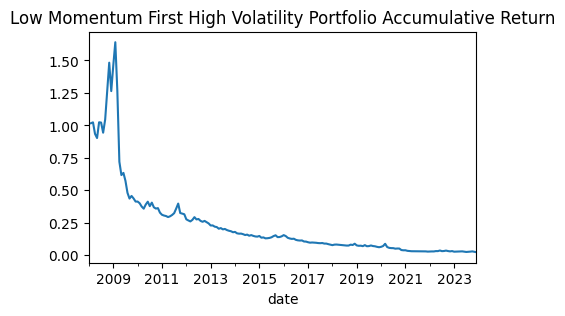

In [25]:
# Calculate the cumulative return
cumulative_return = (1 + equal_weight_portfolio_low_momentumFirst_high_volatility).cumprod()
print("Total return of the low momentum first high volatility portfolio is:", cumulative_return[-1])

# Calculate the annualized return
annualized_return = (cumulative_return[-1]) ** (1/15) - 1
print("The annualized return of the low momentum first high volatility portfolio is:", annualized_return)

# Calculate the annualized volatility
annualized_volatility = equal_weight_portfolio_low_momentumFirst_high_volatility.std() * np.sqrt(12)
print("The annualized volatility of the low momentum first high volatility portfolio is:", annualized_volatility)

# Cacluate the Sharpe ratio
sharpe_ratio = equal_weight_portfolio_low_momentumFirst_high_volatility.mean() / equal_weight_portfolio_low_momentumFirst_high_volatility.std() * np.sqrt(12)
print("The Sharpe ratio of the low momentum first high volatility portfolio is:", sharpe_ratio)

# Calculate the VaR
VaR = equal_weight_portfolio_low_momentumFirst_high_volatility.quantile(0.05)
print("The VaR of the low momentum first high volatility portfolio is:", VaR)

# Plot the cumulative return
plt.figure(figsize=(5, 3))
cumulative_return.plot(title='Low Momentum First High Volatility Portfolio Accumulative Return')

# Store the results in the results table
results_df.loc['Low Momentum First High Volatility Portfolio', 'Total Return'] = cumulative_return[-1]
results_df.loc['Low Momentum First High Volatility Portfolio', 'Annualized Return'] = annualized_return
results_df.loc['Low Momentum First High Volatility Portfolio', 'Annualized Volatility'] = annualized_volatility
results_df.loc['Low Momentum First High Volatility Portfolio', 'Sharpe Ratio'] = sharpe_ratio
results_df.loc['Low Momentum First High Volatility Portfolio', 'VaR'] = VaR


#### 4. Low Momentum from High Volatility Universe

In [26]:
# Firstly selecte the high volatility stocks
HighVolatilityFirst_LowMomentum_df = pd.DataFrame(index=rolling_12_months_return_df.index, columns=rolling_12_months_return_df.columns)
HighVolatilityFirst_LowMomentum_df.iloc[:,:] = np.nan

# Copy the rolling 12 months return dataframe to avoid changing the original dataframe
rolling_12_months_return_df_copy = rolling_12_months_return_df.copy()

# Firstly selecte the high volatility stocks
N_high_volatility = len(tickers) // 2
high_volatility_mask = last_month_rolling_3_years_std_df.rank(axis=1, method='dense', ascending=False) <= N_high_volatility
HighVolatilityFirst_LowMomentum_df[high_volatility_mask] = -1

# Set the low volatility stocks to be nan so that we will only select stocks of low momentum from the high volatility stocks
rolling_12_months_return_df_copy[~high_volatility_mask] = np.nan

# Select the low momentum stocks from the high volatility stocks

# Set the number of low momentum stocks to be half of the high volatility stocks number
N_low_momentum = N_high_volatility // 2
low_momentum_mask = rolling_12_months_return_df_copy.rank(axis=1, method='dense', ascending=True) <= N_low_momentum

# Denote the low momentum stocks to be 1 and the high momentum stocks to be nan
HighVolatilityFirst_LowMomentum_df[low_momentum_mask] = -1
HighVolatilityFirst_LowMomentum_df[~low_momentum_mask] = np.nan

# Get the returns
returns_df_for_high_volatilityFirst_low_momentum = pd.DataFrame(index=rolling_12_months_return_df.index, columns=rolling_12_months_return_df.columns)
returns_df_for_high_volatilityFirst_low_momentum.iloc[:, :] = np.nan

# Perform element-wise multiplication to get the returns of the high volatility first low momentum portfolio
returns_df_for_high_volatilityFirst_low_momentum = next_intra_month_return_df*HighVolatilityFirst_LowMomentum_df

# Get the equal weighted portfolio
equal_weight_portfolio_high_volatilityFirst_low_momentum = returns_df_for_high_volatilityFirst_low_momentum.mean(axis=1, skipna=True).shift()

print(equal_weight_portfolio_high_volatilityFirst_low_momentum.tail(5))


date
2023-08    0.036237
2023-09    0.059416
2023-10    0.063183
2023-11   -0.104322
2023-12   -0.115595
Freq: M, dtype: object


Total return of the high volatility first low momentum portfolio is: 0.035408062978393995
The annualized return of the high volatility first low momentum portfolio is: -0.1996619257762906
The annualized volatility of the high volatility first low momentum portfolio is: 0.253427503795923
The Sharpe ratio of the high volatility first low momentum portfolio is: -0.687782653047047
The VaR of the high volatility first low momentum portfolio is: -0.11831871077455591


<Axes: title={'center': 'High Volatility First Low Momentum Portfolio Accumulative Return'}, xlabel='date'>

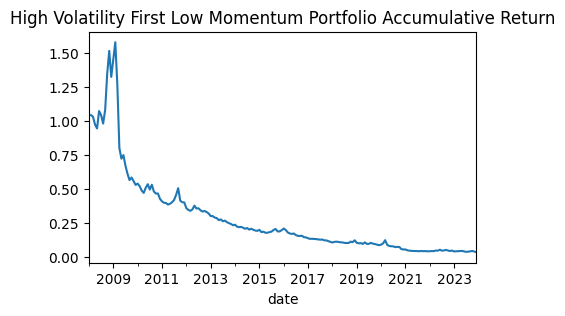

In [27]:
# Calculate the cumulative return
cumulative_return = (1 + equal_weight_portfolio_high_volatilityFirst_low_momentum).cumprod()
print("Total return of the high volatility first low momentum portfolio is:", cumulative_return[-1])

# Calculate the annualized return
annualized_return = (cumulative_return[-1]) ** (1/15) - 1
print("The annualized return of the high volatility first low momentum portfolio is:", annualized_return)

# Calculate the annualized volatility
annualized_volatility = equal_weight_portfolio_high_volatilityFirst_low_momentum.std() * np.sqrt(12)
print("The annualized volatility of the high volatility first low momentum portfolio is:", annualized_volatility)

# Cacluate the Sharpe ratio
sharpe_ratio = equal_weight_portfolio_high_volatilityFirst_low_momentum.mean() / equal_weight_portfolio_high_volatilityFirst_low_momentum.std() * np.sqrt(12)
print("The Sharpe ratio of the high volatility first low momentum portfolio is:", sharpe_ratio)

# Calculate the VaR
VaR = equal_weight_portfolio_high_volatilityFirst_low_momentum.quantile(0.05)
print("The VaR of the high volatility first low momentum portfolio is:", VaR)

# Store the results in the results table
results_df.loc['High Volatility First Low Momentum Portfolio', 'Total Return'] = cumulative_return[-1]
results_df.loc['High Volatility First Low Momentum Portfolio', 'Annualized Return'] = annualized_return
results_df.loc['High Volatility First Low Momentum Portfolio', 'Annualized Volatility'] = annualized_volatility
results_df.loc['High Volatility First Low Momentum Portfolio', 'Sharpe Ratio'] = sharpe_ratio
results_df.loc['High Volatility First Low Momentum Portfolio', 'VaR'] = VaR

# Plot the cumulative return
plt.figure(figsize=(5, 3))
cumulative_return.plot(title='High Volatility First Low Momentum Portfolio Accumulative Return')


# Strategy Implementation on Low Volatility Stocks Only

Follow the regression analysis, let's implement the strategies on the tail of low volatility stocks

In [28]:
# Create a table to store the results
columns = ['Total Return', 'Annualized Return', 'Annualized Volatility', 'Sharpe Ratio', 'VaR']
index = ['Pure Momentum Portfolio','High Momentum Portfolio','Pure Volatility Portfolio', 'Low Volatility Portfolio', 
         'High Momentum First Low Volatility Portfolio', 'Low Volatility First High Momentum Portfolio',
         'Low Momentum First High Volatility Portfolio', 'High Volatility First Low Momentum Portfolio']
results_df_low_vol = pd.DataFrame(index=index, columns=columns)
results_df_low_vol.iloc[:, :] = np.nan

In [29]:
# We first select the low volatility stocks
N = 40
# Get the volatility of the stocks with the lowest volatility
low_vol_stocks_df = last_month_rolling_3_years_std_df.mask(last_month_rolling_3_years_std_df.rank(axis=1, method='dense', ascending = False) > N,np.nan)
# Get the returns of the low volatility stocks
low_vol_returns_df = next_intra_month_return_df[low_vol_stocks_df.notna()]
# Get the momentum of the low volatility stocks
low_vol_momentum_df = rolling_12_months_return_df[low_vol_stocks_df.notna()]

## Pure Play Portfolio

### Pure Momentum Portfolio

In [30]:
N_pure_momentum = N//2
high_momentum_mask = low_vol_momentum_df.rank(axis=1, method='dense', ascending= True) > N_pure_momentum
low_momentum_mask = low_vol_momentum_df.rank(axis=1, method='dense', ascending= False) > N_pure_momentum
# Get the returns for the pure momentum portfolio
returns_df_for_pure_momentum = pd.DataFrame(index=rolling_12_months_return_df.index, columns=rolling_12_months_return_df.columns)
returns_df_for_pure_momentum.iloc[:, :] = np.nan
returns_df_for_pure_momentum[high_momentum_mask] = low_vol_returns_df[high_momentum_mask]
returns_df_for_pure_momentum[low_momentum_mask] = -low_vol_returns_df[low_momentum_mask]
# Build the equal weighted portfolio for the pure momentum portfolio
equal_weighted_returns = returns_df_for_pure_momentum.mean(axis=1, skipna=True).shift()
print(equal_weighted_returns.tail())


date
2023-08   -0.013109
2023-09   -0.002704
2023-10    0.012541
2023-11    0.040546
2023-12   -0.006819
Freq: M, dtype: object


The accumulated return for the equal weighted portfolio is:  0.605492847558396
The annualized return for the equal weighted portfolio is:  -0.0026096749484092463
The annualized volatility for the equal weighted portfolio is:  0.10852972458982095
The Sharpe ratio for the equal weighted portfolio is:  -0.02404571612313857
The VaR for the equal weighted portfolio is:  -0.05300985830542443


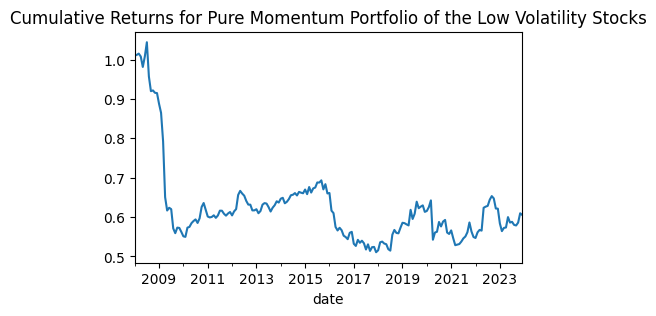

In [31]:
# Calculate the cumulative returns
cumulative_returns = (1 + equal_weighted_returns).cumprod()
print("The accumulated return for the equal weighted portfolio is: ", cumulative_returns[-1])

# Calculate the annualized return
annualized_return = (cumulative_returns[-1])**(1/len(cumulative_returns)) - 1
print("The annualized return for the equal weighted portfolio is: ", annualized_return)

# Calculate the annualized volatility
annualized_volatility = equal_weighted_returns.std() * np.sqrt(12)
print("The annualized volatility for the equal weighted portfolio is: ", annualized_volatility)

# Calculate the Sharpe ratio
sharpe_ratio = annualized_return / annualized_volatility
print("The Sharpe ratio for the equal weighted portfolio is: ", sharpe_ratio)

# Calculate the VaR
VaR = equal_weighted_returns.quantile(0.05)
print("The VaR for the equal weighted portfolio is: ", VaR)

# Plot the cumulative returns
plt.figure(figsize=(5, 3))
cumulative_returns.plot()
plt.title('Cumulative Returns for Pure Momentum Portfolio of the Low Volatility Stocks')

# Store the results in the results dataframe
results_df_low_vol.loc['Pure Momentum Portfolio', 'Total Return'] = cumulative_returns[-1]
results_df_low_vol.loc['Pure Momentum Portfolio', 'Annualized Return'] = annualized_return
results_df_low_vol.loc['Pure Momentum Portfolio', 'Annualized Volatility'] = annualized_volatility
results_df_low_vol.loc['Pure Momentum Portfolio', 'Sharpe Ratio'] = sharpe_ratio
results_df_low_vol.loc['Pure Momentum Portfolio', 'VaR'] = VaR

### Pure High Momentum Portfolio

In [32]:
N_pure_high_momentum = N // 2
high_momentum_mask = low_vol_momentum_df.rank(axis=1, method='dense', ascending = True) > N_pure_high_momentum
# Get the returns for the high momentum stocks
returns_df_for_pure_high_momentum = pd.DataFrame(index=rolling_12_months_return_df.index, columns=rolling_12_months_return_df.columns)
returns_df_for_pure_high_momentum.iloc[:, :] = np.nan
returns_df_for_pure_high_momentum = low_vol_returns_df[high_momentum_mask]
# Build the equal weighted portfolio for the high momentum stocks
equal_weight_portfolio_pure_high_momentum = returns_df_for_pure_high_momentum.mean(axis=1).shift()
print(equal_weight_portfolio_pure_high_momentum.tail(5))


date
2023-08   -0.059270
2023-09   -0.086604
2023-10   -0.097451
2023-11    0.158376
2023-12    0.109614
Freq: M, dtype: float64


The accumulative return of the high momentum portfolio is: 25.19927682235935
The annualized return of the high momentum portfolio is: 0.22345149179962376
The annualized volatility of the high momentum portfolio is: 0.28609661560581184
The Sharpe ratio of the high momentum portfolio is: 0.7810350756036154
The VaR at 95% confidence level of the high momentum portfolio is: -0.12078546328684206


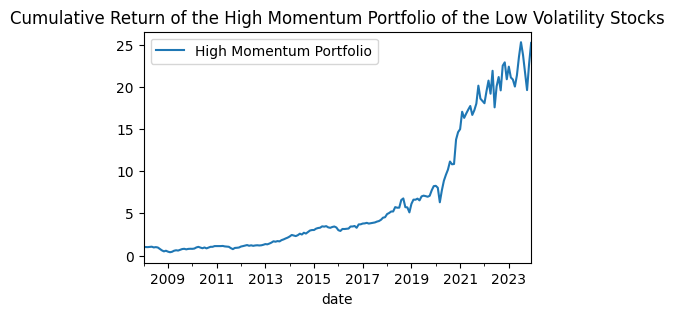

In [33]:
# calculate the cumulative return
cumulative_return_high_momentum = (1 + equal_weight_portfolio_pure_high_momentum).cumprod()
print("The accumulative return of the high momentum portfolio is:", cumulative_return_high_momentum[-1])

# Calculate the annualized return
annualized_return_high_momentum = cumulative_return_high_momentum[-1] ** (12 / len(cumulative_return_high_momentum)) - 1
print("The annualized return of the high momentum portfolio is:", annualized_return_high_momentum)

# Calculate the annualized volatility
annualized_volatility_high_momentum = equal_weight_portfolio_pure_high_momentum.std() * np.sqrt(12)
print("The annualized volatility of the high momentum portfolio is:", annualized_volatility_high_momentum)

# Calculate the Sharpe ratio
sharpe_ratio_high_momentum = annualized_return_high_momentum / annualized_volatility_high_momentum
print("The Sharpe ratio of the high momentum portfolio is:", sharpe_ratio_high_momentum)

# Calculate the VaR at 95% confidence level
VaR_95_high_momentum = equal_weight_portfolio_pure_high_momentum.quantile(0.05)
print("The VaR at 95% confidence level of the high momentum portfolio is:", VaR_95_high_momentum)

# Plot the cumulative return of the high momentum portfolio
plt.figure(figsize=(5, 3))
cumulative_return_high_momentum.plot(label='High Momentum Portfolio')
plt.title('Cumulative Return of the High Momentum Portfolio of the Low Volatility Stocks')
plt.legend()

# Store the results in the results table
results_df_low_vol.loc['High Momentum Portfolio', 'Total Return'] = cumulative_return_high_momentum[-1]
results_df_low_vol.loc['High Momentum Portfolio', 'Annualized Return'] = annualized_return_high_momentum
results_df_low_vol.loc['High Momentum Portfolio', 'Annualized Volatility'] = annualized_volatility_high_momentum
results_df_low_vol.loc['High Momentum Portfolio', 'Sharpe Ratio'] = sharpe_ratio_high_momentum
results_df_low_vol.loc['High Momentum Portfolio', 'VaR'] = VaR_95_high_momentum

### Pure Volatility Portfolio

In [34]:
# Get the both the high volatility and low volatility stocks
N_pure_volatility = N // 2
high_volatility_mask = low_vol_momentum_df.rank(axis=1, method='dense', ascending=True) > N_pure_volatility
low_volatility_mask = low_vol_momentum_df.rank(axis=1, method='dense', ascending=False) > N_pure_volatility

# Get the returns
returns_df_for_pure_volatility = pd.DataFrame(index=low_vol_momentum_df.index, columns=low_vol_momentum_df.columns)
returns_df_for_pure_volatility.iloc[:, :] = np.nan
returns_df_for_pure_volatility[high_volatility_mask] = -low_vol_returns_df[high_volatility_mask]
returns_df_for_pure_volatility[low_volatility_mask] = low_vol_returns_df[low_volatility_mask]

# Get the equal weighted portfolio
equal_weighted_returns = returns_df_for_pure_volatility.mean(axis=1, skipna=True).shift()
print(equal_weighted_returns.tail())

date
2023-08    0.013109
2023-09    0.002704
2023-10   -0.012541
2023-11   -0.040546
2023-12    0.006819
Freq: M, dtype: object


The accumulated return for the equal weighted portfolio is:  1.3679428426459106
The annualized return for the equal weighted portfolio is:  0.0016331448216384548
The annualized volatility for the equal weighted portfolio is:  0.10852972458982095
The Sharpe ratio for the equal weighted portfolio is:  0.01504790349197687
The VaR for the equal weighted portfolio is:  -0.04151569604292113


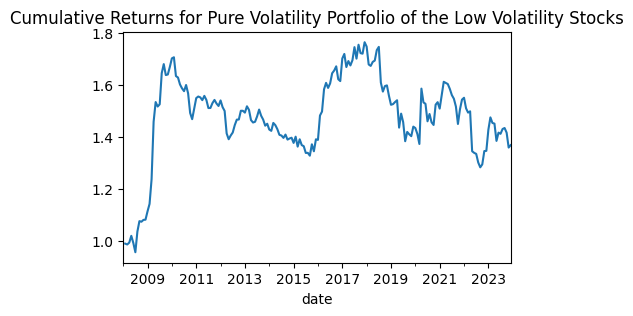

In [35]:
# Calculate the cumulative returns
cumulative_returns = (1 + equal_weighted_returns).cumprod()
print("The accumulated return for the equal weighted portfolio is: ", cumulative_returns[-1])

# Calculate the annualized return
annualized_return = (cumulative_returns[-1])**(1/len(cumulative_returns)) - 1
print("The annualized return for the equal weighted portfolio is: ", annualized_return)

# Calculate the annualized volatility
annualized_volatility = equal_weighted_returns.std() * np.sqrt(12)
print("The annualized volatility for the equal weighted portfolio is: ", annualized_volatility)

# Calculate the Sharpe ratio
sharpe_ratio = annualized_return / annualized_volatility
print("The Sharpe ratio for the equal weighted portfolio is: ", sharpe_ratio)

# Calculate the VaR
VaR = equal_weighted_returns.quantile(0.05)
print("The VaR for the equal weighted portfolio is: ", VaR)

# Plot the cumulative returns
plt.figure(figsize=(5, 3))
cumulative_returns.plot()
plt.title('Cumulative Returns for Pure Volatility Portfolio of the Low Volatility Stocks')

# Store the results in the results table
results_df_low_vol.loc['Pure Volatility Portfolio', 'Total Return'] = cumulative_returns[-1]
results_df_low_vol.loc['Pure Volatility Portfolio', 'Annualized Return'] = annualized_return
results_df_low_vol.loc['Pure Volatility Portfolio', 'Annualized Volatility'] = annualized_volatility
results_df_low_vol.loc['Pure Volatility Portfolio', 'Sharpe Ratio'] = sharpe_ratio
results_df_low_vol.loc['Pure Volatility Portfolio', 'VaR'] = VaR


### Pure Low Volatility Portfolio

In [36]:
# Get the low volatility stocks
N_low_volatility = N // 2
low_volatility_mask = low_vol_stocks_df.rank(axis=1, method='dense', ascending=False) > N_low_volatility

# Get the returns for the low volatility stocks
returns_df_for_low_volatility = pd.DataFrame(index=low_vol_stocks_df.index, columns=low_vol_stocks_df.columns)
returns_df_for_low_volatility.iloc[:, :] = np.nan
returns_df_for_low_volatility = next_intra_month_return_df[low_volatility_mask]

# Build the equal weighted portfolio for the low volatility stocks
equal_weight_portfolio_low_volatility = returns_df_for_low_volatility.mean(axis=1).shift()
print(equal_weight_portfolio_low_volatility.tail(5))


date
2023-08   -0.038329
2023-09   -0.086801
2023-10   -0.094332
2023-11    0.112073
2023-12    0.124659
Freq: M, dtype: float64


The accumulative return of the low volatility portfolio is: 18.661020257032945
The Sharpe ratio of the low volatility portfolio is: 0.7709066036078184
The annualized volatility of the low volatility portfolio is: 0.29502056989481884
The annualized return of the low volatility portfolio is: 0.21542740833191232
The VaR of the low volatility portfolio is: -0.10894682977859776


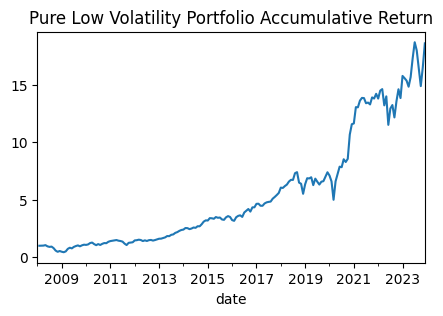

In [37]:
# calculate the cumulative return
cumulative_return_low_volatility = (1 + equal_weight_portfolio_low_volatility).cumprod()
print("The accumulative return of the low volatility portfolio is:", cumulative_return_low_volatility[-1])

# Calculate the Sharpe ratio
sharpe_ratio = equal_weight_portfolio_low_volatility.mean() / equal_weight_portfolio_low_volatility.std()* np.sqrt(12)
print("The Sharpe ratio of the low volatility portfolio is:", sharpe_ratio)

# Calculate the annualized volatility
annualized_volatility = equal_weight_portfolio_low_volatility.std() * np.sqrt(12)
print("The annualized volatility of the low volatility portfolio is:", annualized_volatility)

# Calculate the annualized return
annualized_return = (cumulative_return_low_volatility[-1]) ** (1/15) - 1
print("The annualized return of the low volatility portfolio is:", annualized_return)

# Calculate the VaR
VaR = equal_weight_portfolio_low_volatility.quantile(0.05)
print("The VaR of the low volatility portfolio is:", VaR)

# Plot the cumulative return
plt.figure(figsize=(5, 3))
cumulative_return_low_volatility.plot(title='Pure Low Volatility Portfolio Accumulative Return')

# Store the results in the results table
results_df_low_vol.loc['Low Volatility Portfolio', 'Total Return'] = cumulative_return_low_volatility[-1]
results_df_low_vol.loc['Low Volatility Portfolio', 'Annualized Return'] = annualized_return
results_df_low_vol.loc['Low Volatility Portfolio', 'Annualized Volatility'] = annualized_volatility
results_df_low_vol.loc['Low Volatility Portfolio', 'Sharpe Ratio'] = sharpe_ratio
results_df_low_vol.loc['Low Volatility Portfolio', 'VaR'] = VaR

## Double Screening:  Combined Strategy

#### 1. Low-Volatility Stocks From High Momentum Universe

In [38]:
HighMomentumFirst_LowVolatility_df_low_vol = pd.DataFrame(index = rolling_12_months_return_df.index, columns=rolling_12_months_return_df.columns)
HighMomentumFirst_LowVolatility_df_low_vol.iloc[:, :] = np.nan

# Copy the low_vol_momentum_df to avoid changing the original dataframe
low_vol_stock_df_copy = low_vol_momentum_df.copy()

# Firstly selecte the high momentum stocks
N_high_momentum = N // 2
high_momentum_mask = low_vol_momentum_df.rank(axis=1, method="dense", ascending=True) > N_high_momentum
HighMomentumFirst_LowVolatility_df_low_vol[high_momentum_mask] = 1

# set the low momentum stocks to be nan so that we will only select stocks of low volatility from the high momentum stocks
low_vol_stock_df_copy[~high_momentum_mask] = np.NaN

# Select the low volatility stocks from the high momentum universe
# Set the number of low volatility stocks to be half of the high momentum stocks number
N_low_volatility = N_high_momentum // 2
low_volatility_mask =low_vol_stock_df_copy.rank(axis=1, method='dense', ascending=False) > N_low_volatility
HighMomentumFirst_LowVolatility_df_low_vol[low_volatility_mask] = 1
HighMomentumFirst_LowVolatility_df_low_vol[~low_volatility_mask] = np.nan

# Get the returns
returns_df_for_high_momentumFirst_low_volatility_low_vol = pd.DataFrame(index=rolling_12_months_return_df.index, columns=rolling_12_months_return_df.columns)
returns_df_for_high_momentumFirst_low_volatility_low_vol.iloc[:, :] = np.nan
returns_df_for_high_momentumFirst_low_volatility_low_vol = low_vol_returns_df*HighMomentumFirst_LowVolatility_df_low_vol

# Get the equal weighted portfolio
equal_weight_portfolio_high_momentumFirst_low_volatility_low_vol = returns_df_for_high_momentumFirst_low_volatility_low_vol.mean(axis=1, skipna=True).shift()
print(equal_weight_portfolio_high_momentumFirst_low_volatility.tail())

date
2023-08   -0.004718
2023-09   -0.048402
2023-10    -0.02217
2023-11    0.084242
2023-12     0.03477
Freq: M, dtype: object


Total return of the high momentum first low volatility portfolio is: 14.154757470726889
The annualized return of the high momentum first low volatility portfolio is: 0.19323732226621737
The annualized volatility of the high momentum first low volatility portfolio is: 0.3007055943315561
The Sharpe ratio of the high momentum first low volatility portfolio is: 0.7082913762866252
The VaR of the high momentum first low volatility portfolio is: -0.11974885013948852


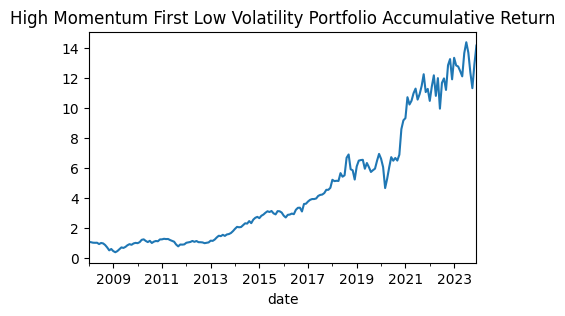

In [39]:
# calculate the cumulative return
cumulative_return = (1 + equal_weight_portfolio_high_momentumFirst_low_volatility_low_vol).cumprod()
print("Total return of the high momentum first low volatility portfolio is:", cumulative_return[-1])

# Calculate the annualized return
annualized_return = (cumulative_return[-1]) ** (1/15) - 1
print("The annualized return of the high momentum first low volatility portfolio is:", annualized_return)

# Calculate the annualized volatility
annualized_volatility = equal_weight_portfolio_high_momentumFirst_low_volatility_low_vol.std() * np.sqrt(12)
print("The annualized volatility of the high momentum first low volatility portfolio is:", annualized_volatility)

# Cacluate the Sharpe ratio
sharpe_ratio = equal_weight_portfolio_high_momentumFirst_low_volatility_low_vol.mean() / equal_weight_portfolio_high_momentumFirst_low_volatility_low_vol.std() * np.sqrt(12)
print("The Sharpe ratio of the high momentum first low volatility portfolio is:", sharpe_ratio)

# Calculate the VaR
VaR = equal_weight_portfolio_high_momentumFirst_low_volatility_low_vol.quantile(0.05)
print("The VaR of the high momentum first low volatility portfolio is:", VaR)

# Plot the cumulative return
plt.figure(figsize=(5, 3))
cumulative_return.plot(title='High Momentum First Low Volatility Portfolio Accumulative Return')

# Store the results in the results table
results_df_low_vol.loc['High Momentum First Low Volatility Portfolio', 'Total Return'] = cumulative_return[-1]
results_df_low_vol.loc['High Momentum First Low Volatility Portfolio', 'Annualized Return'] = annualized_return
results_df_low_vol.loc['High Momentum First Low Volatility Portfolio', 'Annualized Volatility'] = annualized_volatility
results_df_low_vol.loc['High Momentum First Low Volatility Portfolio', 'Sharpe Ratio'] = sharpe_ratio
results_df_low_vol.loc['High Momentum First Low Volatility Portfolio', 'VaR'] = VaR


#### 2. High Momentum Stock from Low Volatility Universe

In [40]:
# Firstly selecte the low volatility stocks
LowVolatilityFirst_HighMomentum_df_low_vol = pd.DataFrame(index = rolling_12_months_return_df.index, columns=rolling_12_months_return_df.columns)
LowVolatilityFirst_HighMomentum_df_low_vol.iloc[:, :] = np.nan

# Copy the low_vol_stock_df to avoid changing the original dataframe
low_vol_momentum_df_copy = low_vol_momentum_df.copy()

N_low_volatility = N // 2
low_volatility_mask = low_vol_stocks_df.rank(axis=1, method='dense', ascending=False) > N_low_volatility
LowVolatilityFirst_HighMomentum_df_low_vol[low_volatility_mask] = 1

# Set the high volatility stocks to be nan so that we will only select stocks of high momentum from the low volatility stocks
low_vol_momentum_df_copy[~low_volatility_mask] = np.nan

# Select the high momentum stocks from the low volatility stocks
# Set the number of high momentum stocks to be half of the low volatility stocks number
N_high_momentum = N_low_volatility // 2
high_momentum_mask = low_vol_momentum_df_copy.rank(axis=1, method='dense', ascending=True) > N_high_momentum

# Denote the high momentum stocks to be 1 and the low momentum stocks to be nan
LowVolatilityFirst_HighMomentum_df_low_vol[high_momentum_mask] = 1
LowVolatilityFirst_HighMomentum_df_low_vol[~high_momentum_mask] = np.nan

# Get the returns
returns_df_for_low_volatilityFirst_high_momentum_low_vol = pd.DataFrame(index=rolling_12_months_return_df.index, columns=rolling_12_months_return_df.columns)
returns_df_for_low_volatilityFirst_high_momentum_low_vol.iloc[:, :] = np.nan
returns_df_for_low_volatilityFirst_high_momentum_low_vol = low_vol_returns_df*LowVolatilityFirst_HighMomentum_df_low_vol

# Get the equal weighted portfolio
equal_weight_portfolio_low_volatilityFirst_high_momentum_low_vol = returns_df_for_low_volatilityFirst_high_momentum_low_vol.mean(axis=1, skipna=True).shift()

print(equal_weight_portfolio_low_volatilityFirst_high_momentum_low_vol.tail(5))

date
2023-08   -0.043572
2023-09   -0.073046
2023-10   -0.077886
2023-11    0.171116
2023-12    0.111799
Freq: M, dtype: object


Total return of the low volatility first high momentum portfolio is: 24.918115703914513
The annualized return of the low volatility first high momentum portfolio is: 0.2390847536000862
The annualized volatility of the low volatility first high momentum portfolio is: 0.27295331493324115
The Sharpe ratio of the low volatility first high momentum portfolio is: 0.8817399264753442
The VaR of the low volatility first high momentum portfolio is: -0.10083192978732951


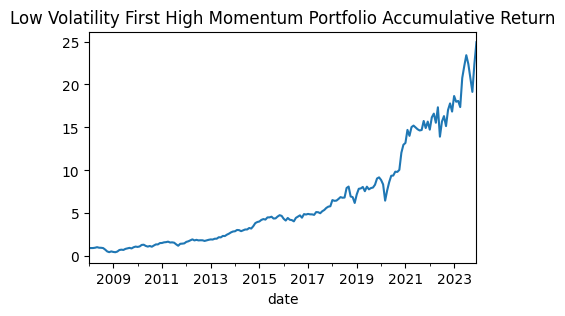

In [41]:
# Calculate the cumulative return
cumulative_return = (1 + equal_weight_portfolio_low_volatilityFirst_high_momentum_low_vol).cumprod()
print("Total return of the low volatility first high momentum portfolio is:", cumulative_return[-1])

# Calculate the annualized return
annualized_return = (cumulative_return[-1]) ** (1/15) - 1
print("The annualized return of the low volatility first high momentum portfolio is:", annualized_return)

# Calculate the annualized volatility
annualized_volatility = equal_weight_portfolio_low_volatilityFirst_high_momentum_low_vol.std() * np.sqrt(12)
print("The annualized volatility of the low volatility first high momentum portfolio is:", annualized_volatility)

# Cacluate the Sharpe ratio
sharpe_ratio = equal_weight_portfolio_low_volatilityFirst_high_momentum_low_vol.mean() / equal_weight_portfolio_low_volatilityFirst_high_momentum_low_vol.std() * np.sqrt(12)
print("The Sharpe ratio of the low volatility first high momentum portfolio is:", sharpe_ratio)

# Calculate the VaR
VaR = equal_weight_portfolio_low_volatilityFirst_high_momentum_low_vol.quantile(0.05)
print("The VaR of the low volatility first high momentum portfolio is:", VaR)

# Plot the cumulative return
plt.figure(figsize=(5, 3))
cumulative_return.plot(title='Low Volatility First High Momentum Portfolio Accumulative Return')


# Store the results in the results table
results_df_low_vol.loc['Low Volatility First High Momentum Portfolio', 'Total Return'] = cumulative_return[-1]
results_df_low_vol.loc['Low Volatility First High Momentum Portfolio', 'Annualized Return'] = annualized_return
results_df_low_vol.loc['Low Volatility First High Momentum Portfolio', 'Annualized Volatility'] = annualized_volatility
results_df_low_vol.loc['Low Volatility First High Momentum Portfolio', 'Sharpe Ratio'] = sharpe_ratio
results_df_low_vol.loc['Low Volatility First High Momentum Portfolio', 'VaR'] = VaR


#### 3. High Volatility from Low Momentum Universe

In [42]:
# Firstly selecte the low momentum stocks
LowMomentumFirst_HighVolatility_df_low_vol = pd.DataFrame(index=rolling_12_months_return_df.index, columns=rolling_12_months_return_df.columns)
LowMomentumFirst_HighVolatility_df_low_vol.iloc[:,:] = np.nan

# Copy the low_vol_stock_df to avoid changing the original dataframe
low_vol_stocks_df_copy = low_vol_stocks_df.copy()

# Firstly selecte the low momentum stocks
N_low_momentum = N // 2
low_momentum_mask = low_vol_momentum_df.rank(axis=1, method='dense', ascending=False) > N_low_momentum
LowMomentumFirst_HighVolatility_df_low_vol[low_momentum_mask] = -1

# Set the high momentum stocks to be nan so that we can only select stocks of high volatility from the low momentum stocks
low_vol_stocks_df_copy[~low_momentum_mask] = np.nan

# Select the high volatility stocks from the low momentum stocks
# Set the number of high volatility stocks to be half of the low momentum stocks number
N_high_volatility = N_low_momentum // 2
high_volatility_mask = low_vol_stocks_df_copy.rank(axis=1, method='dense', ascending=True) > N_high_volatility
# Denote the high volatility stocks to be -1 and the low volatility stocks to be nan
LowMomentumFirst_HighVolatility_df_low_vol[high_volatility_mask] = -1
LowMomentumFirst_HighVolatility_df_low_vol[~high_volatility_mask] = np.nan

# Get the returns
returns_df_for_low_momentumFirst_high_volatility_low_vol = pd.DataFrame(index=rolling_12_months_return_df.index, columns=rolling_12_months_return_df.columns)
returns_df_for_low_momentumFirst_high_volatility_low_vol.iloc[:, :] = np.nan
returns_df_for_low_momentumFirst_high_volatility_low_vol = low_vol_returns_df*LowMomentumFirst_HighVolatility_df_low_vol

# Get the equal weighted portfolio
equal_weight_portfolio_low_momentumFirst_high_volatility_low_vol = returns_df_for_low_momentumFirst_high_volatility_low_vol.mean(axis=1, skipna=True).shift()

print(equal_weight_portfolio_low_momentumFirst_high_volatility_low_vol.tail(5))

date
2023-08    0.052813
2023-09    0.075721
2023-10    0.143653
2023-11   -0.112075
2023-12   -0.115604
Freq: M, dtype: object


Total return of the low momentum first high volatility portfolio is: 0.000359066627762943
The annualized return of the low momentum first high volatility portfolio is: -0.4106883823061548
The annualized volatility of the low momentum first high volatility portfolio is: 0.43044259663100304
The Sharpe ratio of the low momentum first high volatility portfolio is: -0.8507293888358953
The VaR of the low momentum first high volatility portfolio is: -0.20171148442301404


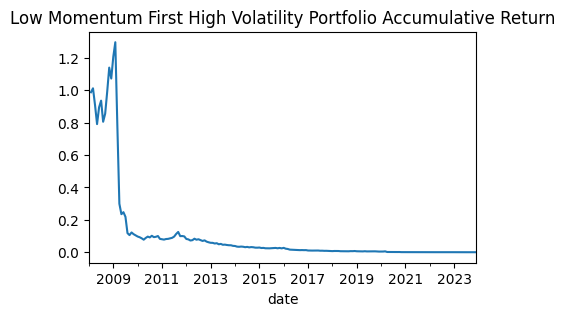

In [43]:
# Calculate the cumulative return
cumulative_return = (1 + equal_weight_portfolio_low_momentumFirst_high_volatility_low_vol).cumprod()
print("Total return of the low momentum first high volatility portfolio is:", cumulative_return[-1])

# Calculate the annualized return
annualized_return = (cumulative_return[-1]) ** (1/15) - 1
print("The annualized return of the low momentum first high volatility portfolio is:", annualized_return)

# Calculate the annualized volatility
annualized_volatility = equal_weight_portfolio_low_momentumFirst_high_volatility_low_vol.std() * np.sqrt(12)
print("The annualized volatility of the low momentum first high volatility portfolio is:", annualized_volatility)

# Cacluate the Sharpe ratio
sharpe_ratio = equal_weight_portfolio_low_momentumFirst_high_volatility_low_vol.mean() / equal_weight_portfolio_low_momentumFirst_high_volatility_low_vol.std() * np.sqrt(12)
print("The Sharpe ratio of the low momentum first high volatility portfolio is:", sharpe_ratio)

# Calculate the VaR
VaR = equal_weight_portfolio_low_momentumFirst_high_volatility_low_vol.quantile(0.05)
print("The VaR of the low momentum first high volatility portfolio is:", VaR)

# Plot the cumulative return
plt.figure(figsize=(5, 3))
cumulative_return.plot(title='Low Momentum First High Volatility Portfolio Accumulative Return')

# Store the results in the results table
results_df_low_vol.loc['Low Momentum First High Volatility Portfolio', 'Total Return'] = cumulative_return[-1]
results_df_low_vol.loc['Low Momentum First High Volatility Portfolio', 'Annualized Return'] = annualized_return
results_df_low_vol.loc['Low Momentum First High Volatility Portfolio', 'Annualized Volatility'] = annualized_volatility
results_df_low_vol.loc['Low Momentum First High Volatility Portfolio', 'Sharpe Ratio'] = sharpe_ratio
results_df_low_vol.loc['Low Momentum First High Volatility Portfolio', 'VaR'] = VaR


#### 4. Low Momentum from  High Volatility Universe

In [44]:
# Firstly selecte the high volatility stocks
HighVolatilityFirst_LowMomentum_df_low_vol = pd.DataFrame(index=rolling_12_months_return_df.index, columns=rolling_12_months_return_df.columns)
HighVolatilityFirst_LowMomentum_df_low_vol.iloc[:,:] = np.nan

# Copy the low_momentum_stocks_df to avoid changing the original dataframe
low_vol_momentum_df_copy = low_vol_momentum_df.copy()

# Firstly selecte the high volatility stocks
N_high_volatility = N // 2
high_volatility_mask = low_vol_stocks_df.rank(axis=1, method='dense', ascending=True) > N_high_volatility
HighVolatilityFirst_LowMomentum_df_low_vol[high_volatility_mask] = -1

# Set the low volatility stocks to be nan so that we can only select the high volatility stocks
low_vol_momentum_df_copy[~high_volatility_mask] = np.nan

# Select the low momentum stocks from the high volatility stocks
# Set the number of low momentum stocks to be half of the high volatility stocks number
N_low_momentum = N_high_volatility // 2
low_momentum_mask = low_vol_momentum_df_copy.rank(axis=1, method='dense', ascending=False) > N_low_momentum

# Denote the low momentum stocks to be -1 and the high momentum stocks to be nan
HighVolatilityFirst_LowMomentum_df_low_vol[low_momentum_mask] = -1
HighVolatilityFirst_LowMomentum_df_low_vol[~low_momentum_mask] = np.nan

# Get the returns
returns_df_for_high_volatilityFirst_low_momentum_low_vol = pd.DataFrame(index=rolling_12_months_return_df.index, columns=rolling_12_months_return_df.columns)
returns_df_for_high_volatilityFirst_low_momentum_low_vol.iloc[:, :] = np.nan
returns_df_for_high_volatilityFirst_low_momentum_low_vol = low_vol_returns_df*HighVolatilityFirst_LowMomentum_df_low_vol

# Get the equal weighted portfolio
equal_weight_portfolio_high_volatilityFirst_low_momentum_low_vol = returns_df_for_high_volatilityFirst_low_momentum_low_vol.mean(axis=1, skipna=True).shift()
print(equal_weight_portfolio_high_volatilityFirst_low_momentum_low_vol.tail(5))


date
2023-08    0.062298
2023-09    0.066147
2023-10    0.130581
2023-11   -0.088236
2023-12   -0.110314
Freq: M, dtype: object


Total return of the high volatility first low momentum portfolio is: 0.0003864673171052302
The annualized return of the high volatility first low momentum portfolio is: -0.4077921159877057
The annualized volatility of the high volatility first low momentum portfolio is: 0.43131672981256136
The Sharpe ratio of the high volatility first low momentum portfolio is: -0.8480265259774032
The VaR of the high volatility first low momentum portfolio is: -0.18944820088342396


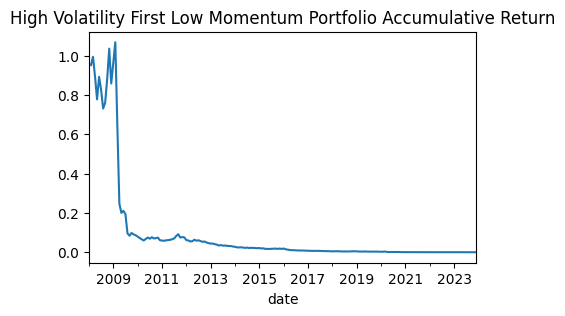

In [45]:
# Calculate the cumulative return
cumulative_return = (1 + equal_weight_portfolio_high_volatilityFirst_low_momentum_low_vol).cumprod()
print("Total return of the high volatility first low momentum portfolio is:", cumulative_return[-1])

# Calculate the annualized return
annualized_return = (cumulative_return[-1]) ** (1/15) - 1
print("The annualized return of the high volatility first low momentum portfolio is:", annualized_return)

# Calculate the annualized volatility
annualized_volatility = equal_weight_portfolio_high_volatilityFirst_low_momentum_low_vol.std() * np.sqrt(12)
print("The annualized volatility of the high volatility first low momentum portfolio is:", annualized_volatility)

# Cacluate the Sharpe ratio
sharpe_ratio = equal_weight_portfolio_high_volatilityFirst_low_momentum_low_vol.mean() / equal_weight_portfolio_high_volatilityFirst_low_momentum_low_vol.std() * np.sqrt(12)
print("The Sharpe ratio of the high volatility first low momentum portfolio is:", sharpe_ratio)

# Calculate the VaR
VaR = equal_weight_portfolio_high_volatilityFirst_low_momentum_low_vol.quantile(0.05)
print("The VaR of the high volatility first low momentum portfolio is:", VaR)

# Plot the cumulative return
plt.figure(figsize=(5, 3))
cumulative_return.plot(title='High Volatility First Low Momentum Portfolio Accumulative Return')

# Store the results in the results table
results_df_low_vol.loc['High Volatility First Low Momentum Portfolio', 'Total Return'] = cumulative_return[-1]
results_df_low_vol.loc['High Volatility First Low Momentum Portfolio', 'Annualized Return'] = annualized_return
results_df_low_vol.loc['High Volatility First Low Momentum Portfolio', 'Annualized Volatility'] = annualized_volatility
results_df_low_vol.loc['High Volatility First Low Momentum Portfolio', 'Sharpe Ratio'] = sharpe_ratio
results_df_low_vol.loc['High Volatility First Low Momentum Portfolio', 'VaR'] = VaR

# Result Analysis

In [46]:
results_df

,Total Return,Annualized Return,Annualized Volatility,Sharpe Ratio,VaR
Pure Momentum Portfolio,0.769182,-0.001366,0.051459,-0.026543,-0.022169
High Momentum Portfolio,6.349371,0.122459,0.17253,0.709785,-0.081288
Pure Volatility Portfolio,1.594498,0.002433,0.06478,0.037557,-0.026322
Low Volatility Portfolio,5.208763,0.116304,0.141286,0.807953,-0.055823
High Momentum First Low Volatility Portfolio,4.06385,0.097984,0.142313,0.692921,-0.062028
Low Volatility First High Momentum Portfolio,3.751048,0.092136,0.143165,0.65426,-0.067709
Low Momentum First High Volatility Portfolio,0.024013,-0.220117,0.271989,-0.706624,-0.13696
High Volatility First Low Momentum Portfolio,0.035408,-0.199662,0.253428,-0.687783,-0.118319


From the table above:
- the Low Volatility First High Momentum Portfolio appears to have the best overall performance, with the highest returns, Sharpe Ratio, and relatively lower risk as measured by annualized volatility and VaR.
- Compared to pure-play high momentum portfolio, the 2 combined portfolio both has higher Sharpe ratio. 
- Compared to the pure-play high mometum portfolio, the Low Volatility First High Momentum Portfolio has higher total return but smaller VaR. 
- When including taking short positions like Pure Momentum Portfolio and Low Momentum First High Volatility Portfolio, the results are unsatisfactory in all cases.

In [47]:
results_df_low_vol

,Total Return,Annualized Return,Annualized Volatility,Sharpe Ratio,VaR
Pure Momentum Portfolio,0.605493,-0.00261,0.10853,-0.024046,-0.05301
High Momentum Portfolio,25.199277,0.223451,0.286097,0.781035,-0.120785
Pure Volatility Portfolio,1.367943,0.001633,0.10853,0.015048,-0.041516
Low Volatility Portfolio,18.66102,0.215427,0.295021,0.770907,-0.108947
High Momentum First Low Volatility Portfolio,14.154757,0.193237,0.300706,0.708291,-0.119749
Low Volatility First High Momentum Portfolio,24.918116,0.239085,0.272953,0.88174,-0.100832
Low Momentum First High Volatility Portfolio,0.000359,-0.410688,0.430443,-0.850729,-0.201711
High Volatility First Low Momentum Portfolio,0.000386,-0.407792,0.431317,-0.848027,-0.189448


After we perform the strategies on the tails, we found:
- High Momentum Portfolio, Pure Low Volatility Portfolio, High Momentum First Low Volatility Portfolio and Low Volatility First High Momentum Portfolio have much better total returns compared to using the whole universe of S&P 500. 
- The long-only strategies will generat much better results than short-only or hybrid strategies.
- In the context of the s&p500's left tail part, which represents the low volatilities, it is true that the lower volatility stocks tend to give higher returns. However, the higher volatility won't lead to lower returns.